In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# --- Style defaults to match my portfolio ---
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Outfit", "Arial", "Helvetica", "DejaVu Sans"]
plt.rcParams["figure.facecolor"] = "#ffffff"
plt.rcParams["axes.facecolor"] = "#ffffff"
plt.rcParams["text.color"] = "#171717"
plt.rcParams["axes.labelcolor"] = "#171717"
plt.rcParams["xtick.color"] = "#171717"
plt.rcParams["ytick.color"] = "#171717"


DATA_PATH = Path("../data/readings.csv")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True)
OVERHEAT_THRESHOLD = 100.0


In [43]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").dropna(subset=["top_oil_temp_c"])
df.head()

,timestamp,transformer_id,transformer_type,mfg_date,top_oil_temp_c
0,2025-08-05 01:00:00+00:00,XFMR-0001,1-ph pad,2019-01-01,89.69
26,2025-08-05 01:00:00+00:00,XFMR-2190,1-ph pad,2023-02-05,103.88
25,2025-08-05 01:00:00+00:00,XFMR-2184,1-ph pad,2023-02-02,103.35
24,2025-08-05 01:00:00+00:00,XFMR-2181,1-ph pad,2023-11-09,106.91
23,2025-08-05 01:00:00+00:00,XFMR-2180,1-ph pad,2021-01-01,104.51


In [44]:
summary = (
    df.groupby("transformer_id")
    .agg(
        avg_temp=("top_oil_temp_c", "mean"),
        max_temp=("top_oil_temp_c", "max"),
        count=("top_oil_temp_c", "size"),
    )
    .sort_values("avg_temp", ascending=False)
    .round(2)
)

summary.to_csv(OUT_DIR / "hot_transformers.csv")
summary

,avg_temp,max_temp,count
transformer_id,,,
XFMR-0426,80.84,109.69,167
XFMR-0009,80.58,109.74,167
XFMR-2180,80.57,108.98,167
XFMR-0003,80.54,107.88,167
XFMR-0430,80.44,108.87,167
XFMR-0005,80.42,108.80,167
XFMR-0007,80.40,109.29,167
XFMR-0405,80.28,108.89,167
XFMR-0407,80.28,105.69,167


In [45]:
overheat = (
    df.assign(over_thresh=lambda d: d["top_oil_temp_c"] > OVERHEAT_THRESHOLD)
      .groupby("transformer_id")["over_thresh"]
      .sum()
      .rename("hours_over_thresh")
      .sort_values(ascending=False)
)

risk = summary.join(overheat, how="left").fillna(0).astype({"hours_over_thresh": int})
risk.to_csv(OUT_DIR / "hot_transformers.csv")  # overwrite with richer table
risk


,avg_temp,max_temp,count,hours_over_thresh
transformer_id,,,,
XFMR-0426,80.84,109.69,167,22
XFMR-0009,80.58,109.74,167,18
XFMR-2180,80.57,108.98,167,19
XFMR-0003,80.54,107.88,167,20
XFMR-0430,80.44,108.87,167,21
XFMR-0005,80.42,108.80,167,19
XFMR-0007,80.40,109.29,167,16
XFMR-0405,80.28,108.89,167,20
XFMR-0407,80.28,105.69,167,19


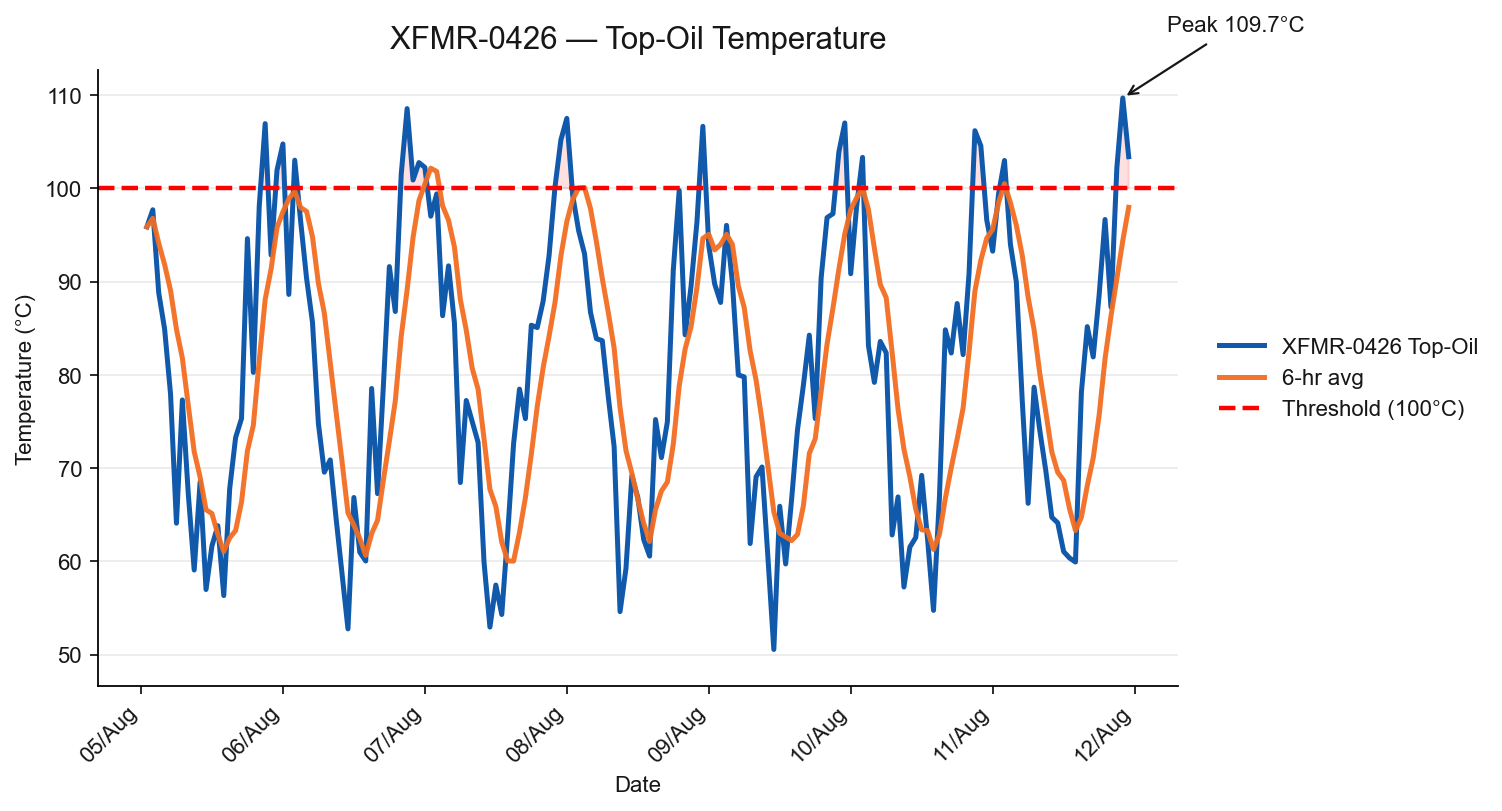

In [46]:
t_id = risk.index[0] if len(risk.index) else df["transformer_id"].iloc[0]
df_one = df[df["transformer_id"] == t_id].copy().sort_values("timestamp")
df_one["rolling_6h"] = df_one["top_oil_temp_c"].rolling(window=6, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10, 5.5), dpi=160)

# Main series
ax.plot(df_one["timestamp"], df_one["top_oil_temp_c"], linewidth=2.25,
        label=f"{t_id} Top-Oil", color="#1059ab")

# Rolling average
ax.plot(df_one["timestamp"], df_one["rolling_6h"], linewidth=2.25,
        label="6-hr avg", color="#f26d21", alpha=0.95)

# Threshold
ax.axhline(OVERHEAT_THRESHOLD, linestyle="--", linewidth=2, color="red",
           label=f"Threshold ({OVERHEAT_THRESHOLD:.0f}°C)")

# Shade exceedances
ax.fill_between(df_one["timestamp"], df_one["top_oil_temp_c"], OVERHEAT_THRESHOLD,
                where=(df_one["top_oil_temp_c"] > OVERHEAT_THRESHOLD),
                alpha=0.12, color="red", interpolate=True)

# Peak annotation (with background box so it never gets lost)
if not df_one.empty:
    imax = df_one["top_oil_temp_c"].idxmax()
    ax.annotate(
        f"Peak {df_one.loc[imax,'top_oil_temp_c']:.1f}°C",
        xy=(df_one.loc[imax, "timestamp"], df_one.loc[imax, "top_oil_temp_c"]),
        xytext=(20, 30), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=1, color="#171717"),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.85)
    )

# Labels, grid, axes cleanup
ax.set_title(f"{t_id} — Top-Oil Temperature", fontsize=14, pad=10)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)

# Date formatting and spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%b"))
plt.xticks(rotation=45, ha="right")
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 1, ymax)

# Legend OUTSIDE to the right
leg = ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# Make room for the outside legend
plt.subplots_adjust(right=0.8, bottom=0.18)

# Save PNG + SVG (crisp for portfolio)
fig.savefig(OUT_DIR / "trend_1.png", dpi=200, bbox_inches="tight")
fig.savefig(OUT_DIR / "trend_1.svg", bbox_inches="tight")
plt.show()
